# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

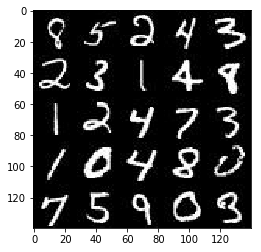

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

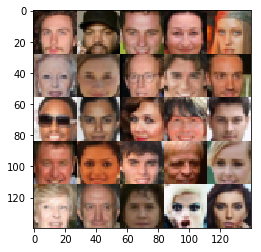

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], 
                                name='real_input')
    z_input = tf.placeholder(tf.float32, shape=[None, z_dim], 
                                name='z_input')
    learning_rate = tf.placeholder(tf.float32)

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x?
        
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(tf.multiply(alpha, conv1), conv1)
        # 14x14x64
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(tf.multiply(alpha, conv2), conv2)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(tf.multiply(alpha, conv3), conv3)
        # 7x7x128
        
        flat = tf.reshape(conv3, [-1, 4*4*256])
        
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        x = tf.layers.dense(z, 4*4*256)
        x = tf.reshape(x, [-1, 4, 4, 256])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(tf.multiply(alpha, x), x)
        # 4x4x256
        
        conv1 = tf.layers.conv2d_transpose(x, 128, 4, strides=1, padding='valid')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(tf.multiply(alpha, conv1), conv1)
        # 7x7x128
        
        conv2 = tf.layers.conv2d_transpose(conv1, 64, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(tf.multiply(alpha, conv2), conv2)
        # 14x14x64
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x$out_channel_dim
        
    return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(input_real, False)
    d_model_z, d_logits_z = discriminator(g_model, True)
 
    # Cost for real
    d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real))
    d_loss_real = tf.reduce_mean(d_loss_real)
    
    # Loss for z
    d_loss_z = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_z, labels=tf.zeros_like(d_model_z))
    d_loss_z = tf.reduce_mean(d_loss_z)
    
    # Loss for generator
    g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_z, labels=tf.ones_like(d_model_z))
    g_loss = tf.reduce_mean(g_loss)
    
    # Overall discriminator Loss
    d_loss = tf.add(d_loss_real, d_loss_z)
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_loss_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_loss_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)

    return d_loss_opt, g_loss_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    
    # Build graph inputs
    if data_image_mode == 'RGB': 
        real_size = [28, 28, 3]
    else: 
        real_size = [28, 28, 1]
        
    input_real, input_z, _ = model_inputs(*real_size, z_dim)
    
    # Loss
    d_loss, g_loss = model_loss(input_real, input_z, real_size[2])
        
    # Optimization
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run the GAN
                _ = sess.run(d_opt, feed_dict={ input_real: batch_images,
                                                input_z: batch_z })
                _ = sess.run(g_opt, feed_dict={ input_z: batch_z, 
                                                input_real: batch_images })
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({ input_z: batch_z, 
                                                 input_real: batch_images })
                    train_loss_g = g_loss.eval({ input_z: batch_z})

                    print("Epoch {}...".format(epoch_i+1),
                          "Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    #def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
                    show_generator_output(sess, 16, input_z, real_size[2], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1... Step 10... Discriminator Loss: 0.3514... Generator Loss: 3.6817
Epoch 1... Step 20... Discriminator Loss: 1.7583... Generator Loss: 4.1071
Epoch 1... Step 30... Discriminator Loss: 2.0495... Generator Loss: 3.6404
Epoch 1... Step 40... Discriminator Loss: 0.8062... Generator Loss: 3.7574
Epoch 1... Step 50... Discriminator Loss: 1.4921... Generator Loss: 6.9724
Epoch 1... Step 60... Discriminator Loss: 0.8747... Generator Loss: 4.1330
Epoch 1... Step 70... Discriminator Loss: 0.7243... Generator Loss: 1.0075
Epoch 1... Step 80... Discriminator Loss: 1.2220... Generator Loss: 0.4310
Epoch 1... Step 90... Discriminator Loss: 0.5535... Generator Loss: 1.1803
Epoch 1... Step 100... Discriminator Loss: 1.4501... Generator Loss: 0.3422


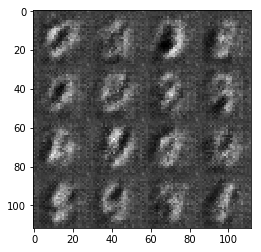

Epoch 1... Step 110... Discriminator Loss: 1.5888... Generator Loss: 0.2841
Epoch 1... Step 120... Discriminator Loss: 1.5906... Generator Loss: 0.3004
Epoch 1... Step 130... Discriminator Loss: 1.4505... Generator Loss: 0.3370
Epoch 1... Step 140... Discriminator Loss: 1.2417... Generator Loss: 0.4465
Epoch 1... Step 150... Discriminator Loss: 1.3822... Generator Loss: 0.3664
Epoch 1... Step 160... Discriminator Loss: 1.2671... Generator Loss: 0.3981
Epoch 1... Step 170... Discriminator Loss: 1.0428... Generator Loss: 0.5583
Epoch 1... Step 180... Discriminator Loss: 1.1756... Generator Loss: 0.4482
Epoch 1... Step 190... Discriminator Loss: 1.5362... Generator Loss: 0.2985
Epoch 1... Step 200... Discriminator Loss: 1.0055... Generator Loss: 0.5479


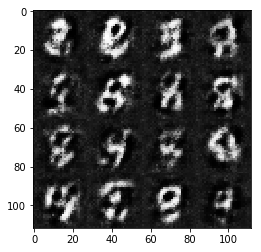

Epoch 1... Step 210... Discriminator Loss: 1.3065... Generator Loss: 0.3786
Epoch 1... Step 220... Discriminator Loss: 1.0326... Generator Loss: 0.5384
Epoch 1... Step 230... Discriminator Loss: 1.3575... Generator Loss: 0.4174
Epoch 1... Step 240... Discriminator Loss: 1.1390... Generator Loss: 0.4613
Epoch 1... Step 250... Discriminator Loss: 1.1428... Generator Loss: 0.4481
Epoch 1... Step 260... Discriminator Loss: 1.1021... Generator Loss: 0.5014
Epoch 1... Step 270... Discriminator Loss: 0.7805... Generator Loss: 0.7860
Epoch 1... Step 280... Discriminator Loss: 1.4736... Generator Loss: 0.2941
Epoch 1... Step 290... Discriminator Loss: 0.9653... Generator Loss: 0.6091
Epoch 1... Step 300... Discriminator Loss: 0.6368... Generator Loss: 1.4732


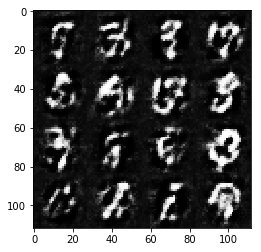

Epoch 1... Step 310... Discriminator Loss: 1.5473... Generator Loss: 3.3044
Epoch 1... Step 320... Discriminator Loss: 0.8580... Generator Loss: 2.1555
Epoch 1... Step 330... Discriminator Loss: 0.5528... Generator Loss: 1.3622
Epoch 1... Step 340... Discriminator Loss: 0.7610... Generator Loss: 2.4577
Epoch 1... Step 350... Discriminator Loss: 0.9368... Generator Loss: 2.7039
Epoch 1... Step 360... Discriminator Loss: 0.5337... Generator Loss: 1.3687
Epoch 1... Step 370... Discriminator Loss: 1.0685... Generator Loss: 2.8844
Epoch 1... Step 380... Discriminator Loss: 0.9301... Generator Loss: 0.6285
Epoch 1... Step 390... Discriminator Loss: 0.9419... Generator Loss: 0.6148
Epoch 1... Step 400... Discriminator Loss: 1.0131... Generator Loss: 0.5409


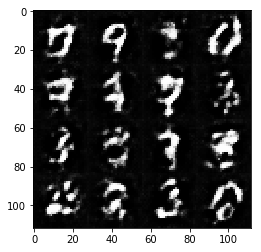

Epoch 1... Step 410... Discriminator Loss: 1.3642... Generator Loss: 0.3603
Epoch 1... Step 420... Discriminator Loss: 1.1569... Generator Loss: 0.4519
Epoch 1... Step 430... Discriminator Loss: 0.7450... Generator Loss: 0.8607
Epoch 1... Step 440... Discriminator Loss: 0.8236... Generator Loss: 2.3050
Epoch 1... Step 450... Discriminator Loss: 0.6257... Generator Loss: 2.1232
Epoch 1... Step 460... Discriminator Loss: 0.6493... Generator Loss: 1.8271
Epoch 1... Step 470... Discriminator Loss: 0.6425... Generator Loss: 1.2762
Epoch 1... Step 480... Discriminator Loss: 1.2005... Generator Loss: 3.4738
Epoch 1... Step 490... Discriminator Loss: 1.0733... Generator Loss: 2.5213
Epoch 1... Step 500... Discriminator Loss: 0.8400... Generator Loss: 0.9907


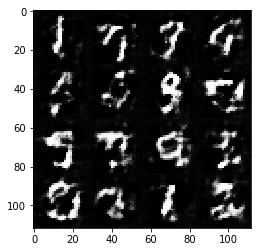

Epoch 1... Step 510... Discriminator Loss: 1.3913... Generator Loss: 0.3466
Epoch 1... Step 520... Discriminator Loss: 1.6789... Generator Loss: 0.2416
Epoch 1... Step 530... Discriminator Loss: 0.7094... Generator Loss: 0.9351
Epoch 1... Step 540... Discriminator Loss: 1.0916... Generator Loss: 0.5154
Epoch 1... Step 550... Discriminator Loss: 1.4747... Generator Loss: 0.3224
Epoch 1... Step 560... Discriminator Loss: 1.4383... Generator Loss: 0.3373
Epoch 1... Step 570... Discriminator Loss: 0.7488... Generator Loss: 1.1274
Epoch 1... Step 580... Discriminator Loss: 0.7045... Generator Loss: 2.2219
Epoch 1... Step 590... Discriminator Loss: 0.7679... Generator Loss: 1.6582
Epoch 1... Step 600... Discriminator Loss: 0.8886... Generator Loss: 2.3399


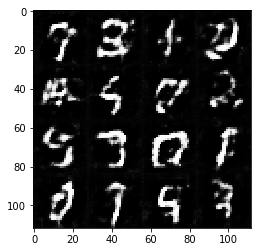

Epoch 1... Step 610... Discriminator Loss: 0.7063... Generator Loss: 0.9135
Epoch 1... Step 620... Discriminator Loss: 0.6123... Generator Loss: 2.0189
Epoch 1... Step 630... Discriminator Loss: 1.1592... Generator Loss: 2.9506
Epoch 1... Step 640... Discriminator Loss: 0.7143... Generator Loss: 1.0170
Epoch 1... Step 650... Discriminator Loss: 0.6291... Generator Loss: 1.2060
Epoch 1... Step 660... Discriminator Loss: 0.8365... Generator Loss: 2.2286
Epoch 1... Step 670... Discriminator Loss: 0.6526... Generator Loss: 1.3330
Epoch 1... Step 680... Discriminator Loss: 0.7567... Generator Loss: 2.0354
Epoch 1... Step 690... Discriminator Loss: 0.8938... Generator Loss: 2.1352
Epoch 1... Step 700... Discriminator Loss: 0.7195... Generator Loss: 1.4268


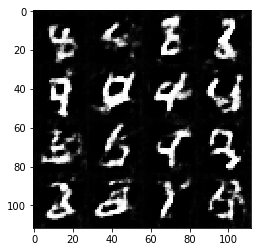

Epoch 1... Step 710... Discriminator Loss: 0.6701... Generator Loss: 1.2196
Epoch 1... Step 720... Discriminator Loss: 1.6996... Generator Loss: 2.9694
Epoch 1... Step 730... Discriminator Loss: 0.6187... Generator Loss: 1.3786
Epoch 1... Step 740... Discriminator Loss: 0.7084... Generator Loss: 0.9739
Epoch 1... Step 750... Discriminator Loss: 0.8627... Generator Loss: 0.6955
Epoch 1... Step 760... Discriminator Loss: 1.2645... Generator Loss: 0.4051
Epoch 1... Step 770... Discriminator Loss: 1.1303... Generator Loss: 0.4949
Epoch 1... Step 780... Discriminator Loss: 1.0203... Generator Loss: 0.5919
Epoch 1... Step 790... Discriminator Loss: 0.8484... Generator Loss: 0.7718
Epoch 1... Step 800... Discriminator Loss: 1.0408... Generator Loss: 0.5618


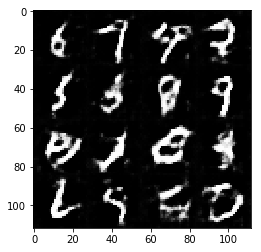

Epoch 1... Step 810... Discriminator Loss: 1.2511... Generator Loss: 0.4017
Epoch 1... Step 820... Discriminator Loss: 3.8641... Generator Loss: 0.0537
Epoch 1... Step 830... Discriminator Loss: 1.0239... Generator Loss: 0.5874
Epoch 1... Step 840... Discriminator Loss: 1.0140... Generator Loss: 0.5685
Epoch 1... Step 850... Discriminator Loss: 0.6816... Generator Loss: 1.0486
Epoch 1... Step 860... Discriminator Loss: 0.7714... Generator Loss: 0.8524
Epoch 1... Step 870... Discriminator Loss: 1.4188... Generator Loss: 0.3726
Epoch 1... Step 880... Discriminator Loss: 1.6375... Generator Loss: 0.3190
Epoch 1... Step 890... Discriminator Loss: 0.7692... Generator Loss: 0.9546
Epoch 1... Step 900... Discriminator Loss: 0.7907... Generator Loss: 0.8773


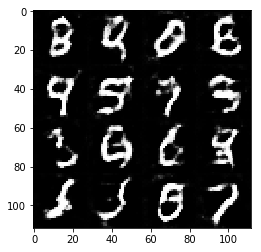

Epoch 1... Step 910... Discriminator Loss: 0.9337... Generator Loss: 0.6792
Epoch 1... Step 920... Discriminator Loss: 1.3938... Generator Loss: 0.3528
Epoch 1... Step 930... Discriminator Loss: 0.7198... Generator Loss: 1.3750
Epoch 2... Step 940... Discriminator Loss: 1.6915... Generator Loss: 2.3343
Epoch 2... Step 950... Discriminator Loss: 0.9417... Generator Loss: 1.6349
Epoch 2... Step 960... Discriminator Loss: 0.8376... Generator Loss: 0.7682
Epoch 2... Step 970... Discriminator Loss: 0.8668... Generator Loss: 0.7294
Epoch 2... Step 980... Discriminator Loss: 1.2004... Generator Loss: 0.5075
Epoch 2... Step 990... Discriminator Loss: 1.1988... Generator Loss: 0.4690
Epoch 2... Step 1000... Discriminator Loss: 1.2929... Generator Loss: 0.4172


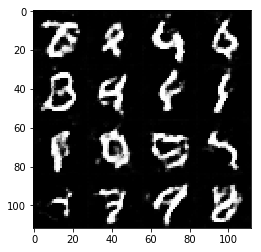

Epoch 2... Step 1010... Discriminator Loss: 1.6612... Generator Loss: 0.3345
Epoch 2... Step 1020... Discriminator Loss: 1.1356... Generator Loss: 0.5057
Epoch 2... Step 1030... Discriminator Loss: 0.7388... Generator Loss: 0.9451
Epoch 2... Step 1040... Discriminator Loss: 0.8184... Generator Loss: 0.7611
Epoch 2... Step 1050... Discriminator Loss: 1.2637... Generator Loss: 0.4144
Epoch 2... Step 1060... Discriminator Loss: 0.9929... Generator Loss: 0.6261
Epoch 2... Step 1070... Discriminator Loss: 0.6912... Generator Loss: 0.9170
Epoch 2... Step 1080... Discriminator Loss: 2.2890... Generator Loss: 4.4170
Epoch 2... Step 1090... Discriminator Loss: 0.7127... Generator Loss: 0.9491
Epoch 2... Step 1100... Discriminator Loss: 0.6527... Generator Loss: 1.0676


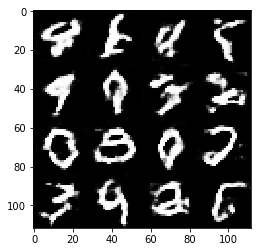

Epoch 2... Step 1110... Discriminator Loss: 0.8043... Generator Loss: 0.8501
Epoch 2... Step 1120... Discriminator Loss: 0.6216... Generator Loss: 1.0841
Epoch 2... Step 1130... Discriminator Loss: 0.7432... Generator Loss: 0.9166
Epoch 2... Step 1140... Discriminator Loss: 1.6241... Generator Loss: 0.2740
Epoch 2... Step 1150... Discriminator Loss: 4.3191... Generator Loss: 0.0243
Epoch 2... Step 1160... Discriminator Loss: 0.9128... Generator Loss: 0.6667
Epoch 2... Step 1170... Discriminator Loss: 0.8103... Generator Loss: 0.7577
Epoch 2... Step 1180... Discriminator Loss: 0.6834... Generator Loss: 0.9990
Epoch 2... Step 1190... Discriminator Loss: 0.5200... Generator Loss: 1.2686
Epoch 2... Step 1200... Discriminator Loss: 0.5162... Generator Loss: 1.5003


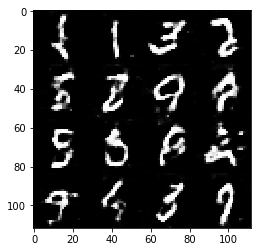

Epoch 2... Step 1210... Discriminator Loss: 1.0906... Generator Loss: 0.5037
Epoch 2... Step 1220... Discriminator Loss: 0.7397... Generator Loss: 0.8845
Epoch 2... Step 1230... Discriminator Loss: 0.6508... Generator Loss: 0.9879
Epoch 2... Step 1240... Discriminator Loss: 0.6463... Generator Loss: 1.7753
Epoch 2... Step 1250... Discriminator Loss: 1.4339... Generator Loss: 2.5803
Epoch 2... Step 1260... Discriminator Loss: 1.1022... Generator Loss: 0.5294
Epoch 2... Step 1270... Discriminator Loss: 1.0209... Generator Loss: 0.6102
Epoch 2... Step 1280... Discriminator Loss: 0.7923... Generator Loss: 0.8422
Epoch 2... Step 1290... Discriminator Loss: 0.5446... Generator Loss: 1.2156
Epoch 2... Step 1300... Discriminator Loss: 0.4940... Generator Loss: 1.3494


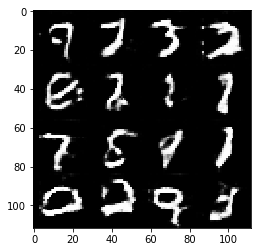

Epoch 2... Step 1310... Discriminator Loss: 0.7723... Generator Loss: 2.3980
Epoch 2... Step 1320... Discriminator Loss: 2.6164... Generator Loss: 3.8011
Epoch 2... Step 1330... Discriminator Loss: 0.6476... Generator Loss: 1.2254
Epoch 2... Step 1340... Discriminator Loss: 1.0271... Generator Loss: 0.6424
Epoch 2... Step 1350... Discriminator Loss: 0.6519... Generator Loss: 0.9957
Epoch 2... Step 1360... Discriminator Loss: 0.7843... Generator Loss: 0.7666
Epoch 2... Step 1370... Discriminator Loss: 0.8703... Generator Loss: 0.7376
Epoch 2... Step 1380... Discriminator Loss: 0.8755... Generator Loss: 0.6839
Epoch 2... Step 1390... Discriminator Loss: 0.7965... Generator Loss: 0.7807
Epoch 2... Step 1400... Discriminator Loss: 2.4952... Generator Loss: 0.1308


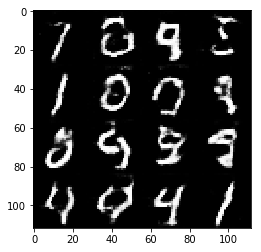

Epoch 2... Step 1410... Discriminator Loss: 1.3870... Generator Loss: 0.3654
Epoch 2... Step 1420... Discriminator Loss: 0.8099... Generator Loss: 0.7892
Epoch 2... Step 1430... Discriminator Loss: 0.9152... Generator Loss: 0.6872
Epoch 2... Step 1440... Discriminator Loss: 0.6250... Generator Loss: 1.0123
Epoch 2... Step 1450... Discriminator Loss: 0.6433... Generator Loss: 0.9958
Epoch 2... Step 1460... Discriminator Loss: 1.9451... Generator Loss: 3.5365
Epoch 2... Step 1470... Discriminator Loss: 0.6144... Generator Loss: 1.1330
Epoch 2... Step 1480... Discriminator Loss: 0.7363... Generator Loss: 0.8582
Epoch 2... Step 1490... Discriminator Loss: 0.5994... Generator Loss: 1.0615
Epoch 2... Step 1500... Discriminator Loss: 0.6489... Generator Loss: 1.0024


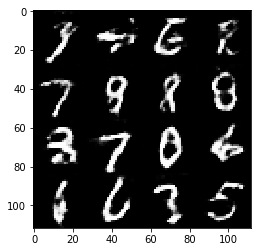

Epoch 2... Step 1510... Discriminator Loss: 0.6965... Generator Loss: 0.9561
Epoch 2... Step 1520... Discriminator Loss: 3.7501... Generator Loss: 5.0109
Epoch 2... Step 1530... Discriminator Loss: 0.8065... Generator Loss: 0.9186
Epoch 2... Step 1540... Discriminator Loss: 0.8021... Generator Loss: 0.8147
Epoch 2... Step 1550... Discriminator Loss: 0.5956... Generator Loss: 1.0690
Epoch 2... Step 1560... Discriminator Loss: 0.5380... Generator Loss: 1.8815
Epoch 2... Step 1570... Discriminator Loss: 0.9175... Generator Loss: 2.6759
Epoch 2... Step 1580... Discriminator Loss: 0.8877... Generator Loss: 0.7073
Epoch 2... Step 1590... Discriminator Loss: 0.4773... Generator Loss: 1.3701
Epoch 2... Step 1600... Discriminator Loss: 1.0270... Generator Loss: 0.5769


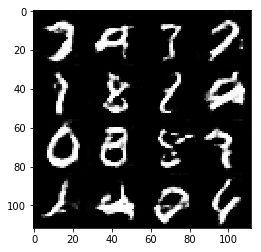

Epoch 2... Step 1610... Discriminator Loss: 0.7048... Generator Loss: 0.8692
Epoch 2... Step 1620... Discriminator Loss: 0.8331... Generator Loss: 3.4455
Epoch 2... Step 1630... Discriminator Loss: 1.4355... Generator Loss: 1.8406
Epoch 2... Step 1640... Discriminator Loss: 0.6951... Generator Loss: 1.8129
Epoch 2... Step 1650... Discriminator Loss: 0.6011... Generator Loss: 1.1066
Epoch 2... Step 1660... Discriminator Loss: 0.5372... Generator Loss: 1.1904
Epoch 2... Step 1670... Discriminator Loss: 0.8729... Generator Loss: 0.6941
Epoch 2... Step 1680... Discriminator Loss: 0.7412... Generator Loss: 0.8296
Epoch 2... Step 1690... Discriminator Loss: 0.6091... Generator Loss: 1.0166
Epoch 2... Step 1700... Discriminator Loss: 0.3940... Generator Loss: 1.4793


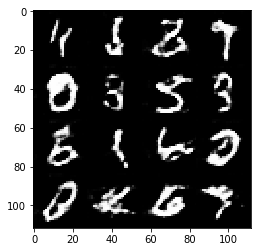

Epoch 2... Step 1710... Discriminator Loss: 0.7300... Generator Loss: 0.8385
Epoch 2... Step 1720... Discriminator Loss: 0.5931... Generator Loss: 1.0545
Epoch 2... Step 1730... Discriminator Loss: 0.4407... Generator Loss: 1.7160
Epoch 2... Step 1740... Discriminator Loss: 0.6821... Generator Loss: 0.9174
Epoch 2... Step 1750... Discriminator Loss: 2.0865... Generator Loss: 0.1758
Epoch 2... Step 1760... Discriminator Loss: 2.6696... Generator Loss: 0.1234
Epoch 2... Step 1770... Discriminator Loss: 1.2497... Generator Loss: 0.4324
Epoch 2... Step 1780... Discriminator Loss: 0.6064... Generator Loss: 1.0915
Epoch 2... Step 1790... Discriminator Loss: 1.1777... Generator Loss: 0.4512
Epoch 2... Step 1800... Discriminator Loss: 1.1082... Generator Loss: 0.5274


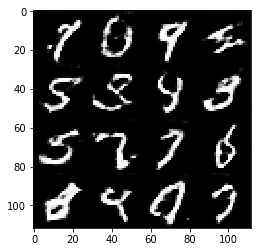

Epoch 2... Step 1810... Discriminator Loss: 2.0065... Generator Loss: 0.2200
Epoch 2... Step 1820... Discriminator Loss: 0.7649... Generator Loss: 0.8467
Epoch 2... Step 1830... Discriminator Loss: 0.6790... Generator Loss: 0.9118
Epoch 2... Step 1840... Discriminator Loss: 1.2358... Generator Loss: 0.4501
Epoch 2... Step 1850... Discriminator Loss: 0.5677... Generator Loss: 1.2282
Epoch 2... Step 1860... Discriminator Loss: 0.6406... Generator Loss: 0.9856
Epoch 2... Step 1870... Discriminator Loss: 0.7715... Generator Loss: 0.8195


In [37]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1... Step 10... Discriminator Loss: 0.2651... Generator Loss: 2.7157
Epoch 1... Step 20... Discriminator Loss: 0.3278... Generator Loss: 2.0403
Epoch 1... Step 30... Discriminator Loss: 2.1697... Generator Loss: 11.6993
Epoch 1... Step 40... Discriminator Loss: 2.7351... Generator Loss: 10.9215
Epoch 1... Step 50... Discriminator Loss: 1.6560... Generator Loss: 0.2851
Epoch 1... Step 60... Discriminator Loss: 3.2750... Generator Loss: 0.0494
Epoch 1... Step 70... Discriminator Loss: 0.9672... Generator Loss: 8.6037
Epoch 1... Step 80... Discriminator Loss: 0.2798... Generator Loss: 1.6655
Epoch 1... Step 90... Discriminator Loss: 0.7183... Generator Loss: 10.0582
Epoch 1... Step 100... Discriminator Loss: 1.0058... Generator Loss: 0.6103


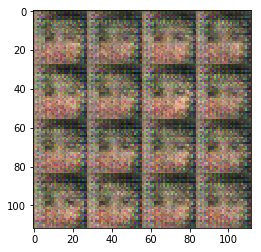

Epoch 1... Step 110... Discriminator Loss: 0.9738... Generator Loss: 10.2230
Epoch 1... Step 120... Discriminator Loss: 0.1572... Generator Loss: 2.4356
Epoch 1... Step 130... Discriminator Loss: 0.4789... Generator Loss: 1.4335
Epoch 1... Step 140... Discriminator Loss: 1.2918... Generator Loss: 13.3205
Epoch 1... Step 150... Discriminator Loss: 0.2753... Generator Loss: 2.4281
Epoch 1... Step 160... Discriminator Loss: 1.1568... Generator Loss: 2.5095
Epoch 1... Step 170... Discriminator Loss: 0.6523... Generator Loss: 1.9834
Epoch 1... Step 180... Discriminator Loss: 0.6168... Generator Loss: 1.4289
Epoch 1... Step 190... Discriminator Loss: 1.5616... Generator Loss: 0.3092
Epoch 1... Step 200... Discriminator Loss: 1.1769... Generator Loss: 0.5843


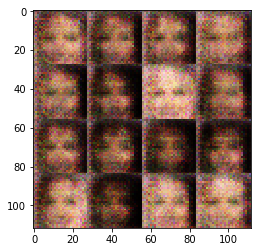

Epoch 1... Step 210... Discriminator Loss: 0.9928... Generator Loss: 0.5613
Epoch 1... Step 220... Discriminator Loss: 1.2532... Generator Loss: 0.5520
Epoch 1... Step 230... Discriminator Loss: 1.1001... Generator Loss: 0.5776
Epoch 1... Step 240... Discriminator Loss: 0.7012... Generator Loss: 3.0087
Epoch 1... Step 250... Discriminator Loss: 1.5351... Generator Loss: 4.1042
Epoch 1... Step 260... Discriminator Loss: 0.6903... Generator Loss: 1.5720
Epoch 1... Step 270... Discriminator Loss: 0.7739... Generator Loss: 2.7629
Epoch 1... Step 280... Discriminator Loss: 0.8651... Generator Loss: 3.3321
Epoch 1... Step 290... Discriminator Loss: 0.7584... Generator Loss: 2.2941
Epoch 1... Step 300... Discriminator Loss: 0.9009... Generator Loss: 2.3602


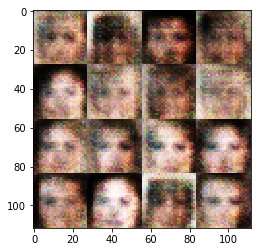

Epoch 1... Step 310... Discriminator Loss: 0.5392... Generator Loss: 1.8841
Epoch 1... Step 320... Discriminator Loss: 0.9905... Generator Loss: 2.1613
Epoch 1... Step 330... Discriminator Loss: 0.9019... Generator Loss: 2.6217
Epoch 1... Step 340... Discriminator Loss: 1.2296... Generator Loss: 2.9751
Epoch 1... Step 350... Discriminator Loss: 1.7183... Generator Loss: 3.4938
Epoch 1... Step 360... Discriminator Loss: 0.7359... Generator Loss: 1.9164
Epoch 1... Step 370... Discriminator Loss: 1.8144... Generator Loss: 4.4854
Epoch 1... Step 380... Discriminator Loss: 0.5451... Generator Loss: 2.3701
Epoch 1... Step 390... Discriminator Loss: 1.0489... Generator Loss: 3.2745
Epoch 1... Step 400... Discriminator Loss: 0.4540... Generator Loss: 1.9561


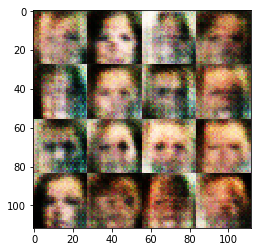

Epoch 1... Step 410... Discriminator Loss: 0.6448... Generator Loss: 2.6007
Epoch 1... Step 420... Discriminator Loss: 1.6007... Generator Loss: 4.2814
Epoch 1... Step 430... Discriminator Loss: 0.8354... Generator Loss: 1.0119
Epoch 1... Step 440... Discriminator Loss: 0.5979... Generator Loss: 1.3302
Epoch 1... Step 450... Discriminator Loss: 2.3065... Generator Loss: 0.1436
Epoch 1... Step 460... Discriminator Loss: 1.2424... Generator Loss: 0.4708
Epoch 1... Step 470... Discriminator Loss: 1.2518... Generator Loss: 0.4575
Epoch 1... Step 480... Discriminator Loss: 1.5903... Generator Loss: 0.2840
Epoch 1... Step 490... Discriminator Loss: 1.7560... Generator Loss: 0.2425
Epoch 1... Step 500... Discriminator Loss: 1.2880... Generator Loss: 0.4472


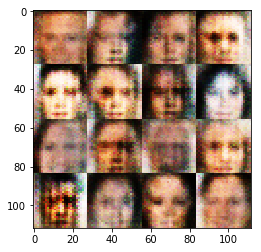

Epoch 1... Step 510... Discriminator Loss: 1.0238... Generator Loss: 0.6088
Epoch 1... Step 520... Discriminator Loss: 1.4423... Generator Loss: 0.3710
Epoch 1... Step 530... Discriminator Loss: 1.3701... Generator Loss: 0.3931
Epoch 1... Step 540... Discriminator Loss: 1.1126... Generator Loss: 0.5438
Epoch 1... Step 550... Discriminator Loss: 1.2055... Generator Loss: 0.4555
Epoch 1... Step 560... Discriminator Loss: 1.2206... Generator Loss: 0.4426
Epoch 1... Step 570... Discriminator Loss: 1.2905... Generator Loss: 0.3923
Epoch 1... Step 580... Discriminator Loss: 1.2546... Generator Loss: 0.4095
Epoch 1... Step 590... Discriminator Loss: 0.9648... Generator Loss: 0.6785
Epoch 1... Step 600... Discriminator Loss: 1.1249... Generator Loss: 0.5180


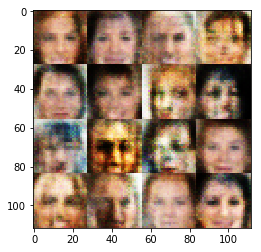

Epoch 1... Step 610... Discriminator Loss: 1.2481... Generator Loss: 0.4248
Epoch 1... Step 620... Discriminator Loss: 1.2704... Generator Loss: 0.3888
Epoch 1... Step 630... Discriminator Loss: 0.9276... Generator Loss: 0.6911
Epoch 1... Step 640... Discriminator Loss: 1.4401... Generator Loss: 0.3612
Epoch 1... Step 650... Discriminator Loss: 1.1945... Generator Loss: 0.4465
Epoch 1... Step 660... Discriminator Loss: 1.3831... Generator Loss: 0.3466
Epoch 1... Step 670... Discriminator Loss: 1.4936... Generator Loss: 0.3327
Epoch 1... Step 680... Discriminator Loss: 1.0478... Generator Loss: 0.5548
Epoch 1... Step 690... Discriminator Loss: 1.0595... Generator Loss: 0.5258
Epoch 1... Step 700... Discriminator Loss: 1.2636... Generator Loss: 0.4508


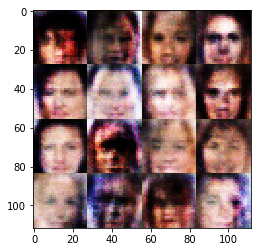

Epoch 1... Step 710... Discriminator Loss: 0.9960... Generator Loss: 0.6171
Epoch 1... Step 720... Discriminator Loss: 1.0533... Generator Loss: 0.5692
Epoch 1... Step 730... Discriminator Loss: 1.4988... Generator Loss: 0.3225
Epoch 1... Step 740... Discriminator Loss: 0.6232... Generator Loss: 1.1029
Epoch 1... Step 750... Discriminator Loss: 0.5318... Generator Loss: 1.1751
Epoch 1... Step 760... Discriminator Loss: 2.4699... Generator Loss: 3.5721
Epoch 1... Step 770... Discriminator Loss: 1.0869... Generator Loss: 1.8803
Epoch 1... Step 780... Discriminator Loss: 0.6838... Generator Loss: 2.5019
Epoch 1... Step 790... Discriminator Loss: 0.7395... Generator Loss: 2.5649
Epoch 1... Step 800... Discriminator Loss: 0.7420... Generator Loss: 2.5296


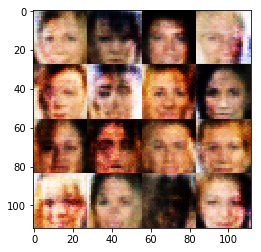

Epoch 1... Step 810... Discriminator Loss: 0.8817... Generator Loss: 1.2559
Epoch 1... Step 820... Discriminator Loss: 0.9264... Generator Loss: 2.5771
Epoch 1... Step 830... Discriminator Loss: 1.0492... Generator Loss: 2.2750
Epoch 1... Step 840... Discriminator Loss: 1.0575... Generator Loss: 3.2734
Epoch 1... Step 850... Discriminator Loss: 0.6464... Generator Loss: 2.9018
Epoch 1... Step 860... Discriminator Loss: 1.0293... Generator Loss: 1.8607
Epoch 1... Step 870... Discriminator Loss: 0.6986... Generator Loss: 1.9875
Epoch 1... Step 880... Discriminator Loss: 0.4821... Generator Loss: 2.6147
Epoch 1... Step 890... Discriminator Loss: 2.5005... Generator Loss: 2.4241
Epoch 1... Step 900... Discriminator Loss: 0.5582... Generator Loss: 1.9890


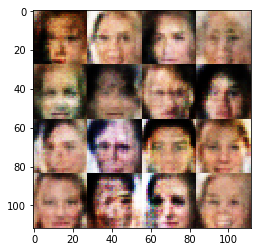

Epoch 1... Step 910... Discriminator Loss: 0.6622... Generator Loss: 2.6788
Epoch 1... Step 920... Discriminator Loss: 0.6830... Generator Loss: 3.0239
Epoch 1... Step 930... Discriminator Loss: 0.6374... Generator Loss: 2.3725
Epoch 1... Step 940... Discriminator Loss: 1.7847... Generator Loss: 2.3298
Epoch 1... Step 950... Discriminator Loss: 0.5211... Generator Loss: 2.0342
Epoch 1... Step 960... Discriminator Loss: 0.6954... Generator Loss: 0.8883
Epoch 1... Step 970... Discriminator Loss: 1.4372... Generator Loss: 0.3509
Epoch 1... Step 980... Discriminator Loss: 0.9311... Generator Loss: 0.6628
Epoch 1... Step 990... Discriminator Loss: 0.8587... Generator Loss: 0.6811
Epoch 1... Step 1000... Discriminator Loss: 1.3882... Generator Loss: 0.3683


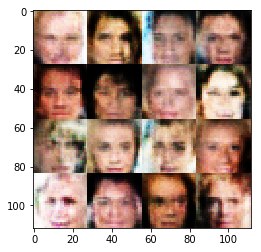

Epoch 1... Step 1010... Discriminator Loss: 0.7329... Generator Loss: 0.8119
Epoch 1... Step 1020... Discriminator Loss: 0.9237... Generator Loss: 0.6449
Epoch 1... Step 1030... Discriminator Loss: 1.2316... Generator Loss: 0.4324
Epoch 1... Step 1040... Discriminator Loss: 1.3543... Generator Loss: 0.3585
Epoch 1... Step 1050... Discriminator Loss: 0.7354... Generator Loss: 0.8434
Epoch 1... Step 1060... Discriminator Loss: 1.0053... Generator Loss: 0.5996
Epoch 1... Step 1070... Discriminator Loss: 0.6308... Generator Loss: 1.0399
Epoch 1... Step 1080... Discriminator Loss: 0.6764... Generator Loss: 2.9325
Epoch 1... Step 1090... Discriminator Loss: 1.1821... Generator Loss: 2.0262
Epoch 1... Step 1100... Discriminator Loss: 0.5369... Generator Loss: 1.7239


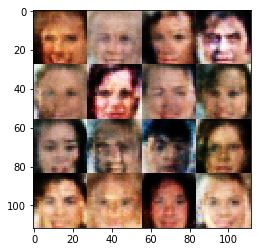

Epoch 1... Step 1110... Discriminator Loss: 0.7161... Generator Loss: 2.9308
Epoch 1... Step 1120... Discriminator Loss: 1.5219... Generator Loss: 2.6788
Epoch 1... Step 1130... Discriminator Loss: 0.5957... Generator Loss: 1.3554
Epoch 1... Step 1140... Discriminator Loss: 0.4865... Generator Loss: 2.6983
Epoch 1... Step 1150... Discriminator Loss: 0.6670... Generator Loss: 2.8093
Epoch 1... Step 1160... Discriminator Loss: 2.0163... Generator Loss: 1.9828
Epoch 1... Step 1170... Discriminator Loss: 0.5811... Generator Loss: 1.5271
Epoch 1... Step 1180... Discriminator Loss: 0.4347... Generator Loss: 2.3460
Epoch 1... Step 1190... Discriminator Loss: 1.5827... Generator Loss: 2.2919
Epoch 1... Step 1200... Discriminator Loss: 0.7494... Generator Loss: 1.0728


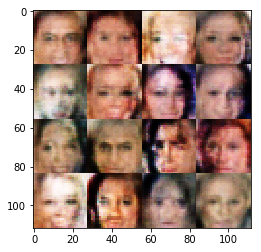

Epoch 1... Step 1210... Discriminator Loss: 0.9931... Generator Loss: 0.5798
Epoch 1... Step 1220... Discriminator Loss: 0.9222... Generator Loss: 0.6216
Epoch 1... Step 1230... Discriminator Loss: 0.7289... Generator Loss: 0.8147
Epoch 1... Step 1240... Discriminator Loss: 0.6050... Generator Loss: 1.1013
Epoch 1... Step 1250... Discriminator Loss: 0.6856... Generator Loss: 0.9049
Epoch 1... Step 1260... Discriminator Loss: 1.4902... Generator Loss: 0.3034
Epoch 1... Step 1270... Discriminator Loss: 1.9653... Generator Loss: 0.2236
Epoch 1... Step 1280... Discriminator Loss: 0.9825... Generator Loss: 0.6337
Epoch 1... Step 1290... Discriminator Loss: 0.9354... Generator Loss: 0.6101
Epoch 1... Step 1300... Discriminator Loss: 0.8470... Generator Loss: 0.7253


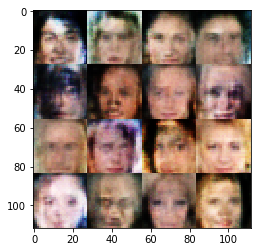

Epoch 1... Step 1310... Discriminator Loss: 0.5695... Generator Loss: 1.0721
Epoch 1... Step 1320... Discriminator Loss: 0.6028... Generator Loss: 1.0861
Epoch 1... Step 1330... Discriminator Loss: 0.3389... Generator Loss: 1.8726
Epoch 1... Step 1340... Discriminator Loss: 1.2022... Generator Loss: 2.6073
Epoch 1... Step 1350... Discriminator Loss: 0.5921... Generator Loss: 1.6030
Epoch 1... Step 1360... Discriminator Loss: 0.3750... Generator Loss: 2.7518
Epoch 1... Step 1370... Discriminator Loss: 0.3913... Generator Loss: 2.0017
Epoch 1... Step 1380... Discriminator Loss: 0.2780... Generator Loss: 2.2460
Epoch 1... Step 1390... Discriminator Loss: 0.9608... Generator Loss: 3.9202
Epoch 1... Step 1400... Discriminator Loss: 1.3248... Generator Loss: 2.2075


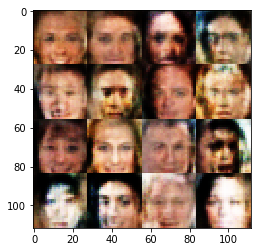

Epoch 1... Step 1410... Discriminator Loss: 0.8203... Generator Loss: 0.7688
Epoch 1... Step 1420... Discriminator Loss: 0.5764... Generator Loss: 1.1850
Epoch 1... Step 1430... Discriminator Loss: 0.6690... Generator Loss: 0.9235
Epoch 1... Step 1440... Discriminator Loss: 0.3257... Generator Loss: 1.7279
Epoch 1... Step 1450... Discriminator Loss: 0.3585... Generator Loss: 1.4792
Epoch 1... Step 1460... Discriminator Loss: 3.0463... Generator Loss: 0.0750
Epoch 1... Step 1470... Discriminator Loss: 0.8486... Generator Loss: 0.6920
Epoch 1... Step 1480... Discriminator Loss: 0.4915... Generator Loss: 1.3099
Epoch 1... Step 1490... Discriminator Loss: 0.5383... Generator Loss: 1.2226
Epoch 1... Step 1500... Discriminator Loss: 0.7740... Generator Loss: 0.7517


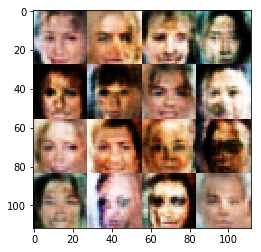

Epoch 1... Step 1510... Discriminator Loss: 0.7270... Generator Loss: 0.8169
Epoch 1... Step 1520... Discriminator Loss: 1.4844... Generator Loss: 4.9495
Epoch 1... Step 1530... Discriminator Loss: 0.8122... Generator Loss: 2.0662
Epoch 1... Step 1540... Discriminator Loss: 0.3817... Generator Loss: 1.8332
Epoch 1... Step 1550... Discriminator Loss: 0.4668... Generator Loss: 1.2915
Epoch 1... Step 1560... Discriminator Loss: 0.7388... Generator Loss: 0.7750
Epoch 1... Step 1570... Discriminator Loss: 0.3378... Generator Loss: 1.9740
Epoch 1... Step 1580... Discriminator Loss: 4.6742... Generator Loss: 4.9527
Epoch 1... Step 1590... Discriminator Loss: 0.9744... Generator Loss: 2.2323
Epoch 1... Step 1600... Discriminator Loss: 0.4751... Generator Loss: 1.9637


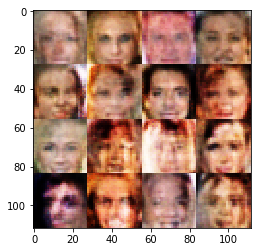

Epoch 1... Step 1610... Discriminator Loss: 0.4378... Generator Loss: 2.6105
Epoch 1... Step 1620... Discriminator Loss: 0.4114... Generator Loss: 1.7090
Epoch 1... Step 1630... Discriminator Loss: 0.6001... Generator Loss: 1.0382
Epoch 1... Step 1640... Discriminator Loss: 0.2799... Generator Loss: 1.8412
Epoch 1... Step 1650... Discriminator Loss: 1.6834... Generator Loss: 0.2714
Epoch 1... Step 1660... Discriminator Loss: 1.4895... Generator Loss: 0.3274
Epoch 1... Step 1670... Discriminator Loss: 0.8945... Generator Loss: 1.9255
Epoch 1... Step 1680... Discriminator Loss: 0.7384... Generator Loss: 2.3467
Epoch 1... Step 1690... Discriminator Loss: 0.5545... Generator Loss: 1.3169
Epoch 1... Step 1700... Discriminator Loss: 1.6254... Generator Loss: 2.8328


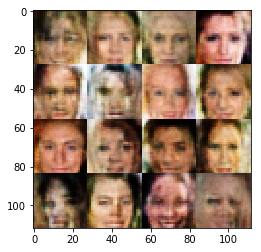

Epoch 1... Step 1710... Discriminator Loss: 0.5330... Generator Loss: 1.6583
Epoch 1... Step 1720... Discriminator Loss: 0.5086... Generator Loss: 2.7769
Epoch 1... Step 1730... Discriminator Loss: 0.6245... Generator Loss: 0.9643
Epoch 1... Step 1740... Discriminator Loss: 0.3192... Generator Loss: 1.8718
Epoch 1... Step 1750... Discriminator Loss: 0.6257... Generator Loss: 0.9548
Epoch 1... Step 1760... Discriminator Loss: 0.2834... Generator Loss: 1.8816
Epoch 1... Step 1770... Discriminator Loss: 3.2924... Generator Loss: 4.0577
Epoch 1... Step 1780... Discriminator Loss: 0.6127... Generator Loss: 1.3749
Epoch 1... Step 1790... Discriminator Loss: 0.9612... Generator Loss: 0.6916
Epoch 1... Step 1800... Discriminator Loss: 1.2684... Generator Loss: 0.4002


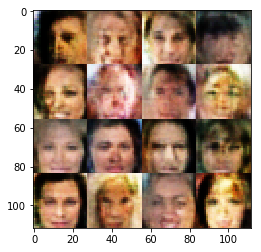

Epoch 1... Step 1810... Discriminator Loss: 2.7143... Generator Loss: 0.0972
Epoch 1... Step 1820... Discriminator Loss: 0.6796... Generator Loss: 0.9552
Epoch 1... Step 1830... Discriminator Loss: 0.8489... Generator Loss: 0.6867
Epoch 1... Step 1840... Discriminator Loss: 0.3532... Generator Loss: 1.7407
Epoch 1... Step 1850... Discriminator Loss: 0.2582... Generator Loss: 2.7417
Epoch 1... Step 1860... Discriminator Loss: 0.3010... Generator Loss: 1.8987
Epoch 1... Step 1870... Discriminator Loss: 0.3250... Generator Loss: 1.7313
Epoch 1... Step 1880... Discriminator Loss: 0.2574... Generator Loss: 1.9593
Epoch 1... Step 1890... Discriminator Loss: 3.4372... Generator Loss: 0.0593
Epoch 1... Step 1900... Discriminator Loss: 1.0660... Generator Loss: 0.5229


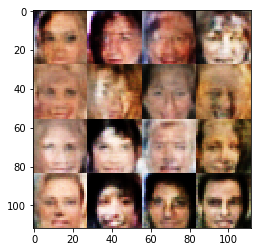

Epoch 1... Step 1910... Discriminator Loss: 0.7919... Generator Loss: 0.8666
Epoch 1... Step 1920... Discriminator Loss: 0.8691... Generator Loss: 0.6789
Epoch 1... Step 1930... Discriminator Loss: 0.4127... Generator Loss: 1.5805
Epoch 1... Step 1940... Discriminator Loss: 0.3739... Generator Loss: 1.5394
Epoch 1... Step 1950... Discriminator Loss: 0.3528... Generator Loss: 1.8677
Epoch 1... Step 1960... Discriminator Loss: 0.5013... Generator Loss: 2.9996
Epoch 1... Step 1970... Discriminator Loss: 0.2747... Generator Loss: 2.0550
Epoch 1... Step 1980... Discriminator Loss: 1.1876... Generator Loss: 0.4481
Epoch 1... Step 1990... Discriminator Loss: 1.8625... Generator Loss: 0.2221
Epoch 1... Step 2000... Discriminator Loss: 0.4883... Generator Loss: 1.7978


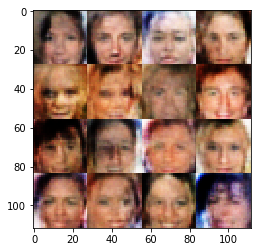

Epoch 1... Step 2010... Discriminator Loss: 0.5510... Generator Loss: 2.1380
Epoch 1... Step 2020... Discriminator Loss: 0.2784... Generator Loss: 2.5757
Epoch 1... Step 2030... Discriminator Loss: 0.7069... Generator Loss: 0.8745
Epoch 1... Step 2040... Discriminator Loss: 1.0120... Generator Loss: 0.5726
Epoch 1... Step 2050... Discriminator Loss: 1.8395... Generator Loss: 0.2202
Epoch 1... Step 2060... Discriminator Loss: 0.4683... Generator Loss: 1.5518
Epoch 1... Step 2070... Discriminator Loss: 0.4855... Generator Loss: 3.0530
Epoch 1... Step 2080... Discriminator Loss: 0.4916... Generator Loss: 1.3014
Epoch 1... Step 2090... Discriminator Loss: 0.5623... Generator Loss: 1.0568
Epoch 1... Step 2100... Discriminator Loss: 0.2558... Generator Loss: 2.2305


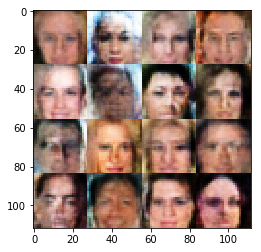

Epoch 1... Step 2110... Discriminator Loss: 0.2315... Generator Loss: 3.3078
Epoch 1... Step 2120... Discriminator Loss: 0.3755... Generator Loss: 4.1728
Epoch 1... Step 2130... Discriminator Loss: 0.9679... Generator Loss: 2.3367
Epoch 1... Step 2140... Discriminator Loss: 0.7126... Generator Loss: 0.8295
Epoch 1... Step 2150... Discriminator Loss: 0.2909... Generator Loss: 1.9987
Epoch 1... Step 2160... Discriminator Loss: 1.2411... Generator Loss: 0.4231
Epoch 1... Step 2170... Discriminator Loss: 1.2277... Generator Loss: 0.4086
Epoch 1... Step 2180... Discriminator Loss: 0.6521... Generator Loss: 0.9130
Epoch 1... Step 2190... Discriminator Loss: 0.5153... Generator Loss: 1.2542
Epoch 1... Step 2200... Discriminator Loss: 1.3801... Generator Loss: 4.7302


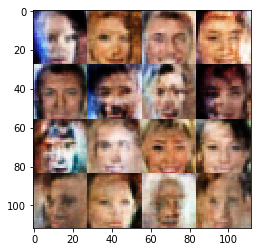

Epoch 1... Step 2210... Discriminator Loss: 0.8098... Generator Loss: 2.2366
Epoch 1... Step 2220... Discriminator Loss: 0.4697... Generator Loss: 1.2215
Epoch 1... Step 2230... Discriminator Loss: 0.4278... Generator Loss: 1.3707
Epoch 1... Step 2240... Discriminator Loss: 0.2379... Generator Loss: 2.7947
Epoch 1... Step 2250... Discriminator Loss: 0.4853... Generator Loss: 1.1024
Epoch 1... Step 2260... Discriminator Loss: 0.2033... Generator Loss: 2.8472
Epoch 1... Step 2270... Discriminator Loss: 2.7857... Generator Loss: 4.7921
Epoch 1... Step 2280... Discriminator Loss: 1.4287... Generator Loss: 2.2858
Epoch 1... Step 2290... Discriminator Loss: 1.3200... Generator Loss: 3.7672
Epoch 1... Step 2300... Discriminator Loss: 1.1784... Generator Loss: 3.2090


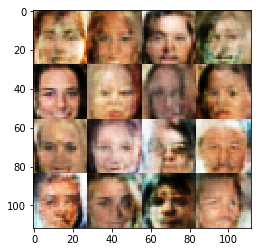

Epoch 1... Step 2310... Discriminator Loss: 0.3472... Generator Loss: 1.9672
Epoch 1... Step 2320... Discriminator Loss: 0.2935... Generator Loss: 2.1590
Epoch 1... Step 2330... Discriminator Loss: 0.4724... Generator Loss: 3.3358
Epoch 1... Step 2340... Discriminator Loss: 0.7696... Generator Loss: 2.2167
Epoch 1... Step 2350... Discriminator Loss: 0.4777... Generator Loss: 1.4466
Epoch 1... Step 2360... Discriminator Loss: 0.3819... Generator Loss: 1.6573
Epoch 1... Step 2370... Discriminator Loss: 1.2132... Generator Loss: 0.4084
Epoch 1... Step 2380... Discriminator Loss: 1.2550... Generator Loss: 0.4211
Epoch 1... Step 2390... Discriminator Loss: 0.4388... Generator Loss: 1.6188
Epoch 1... Step 2400... Discriminator Loss: 0.3723... Generator Loss: 1.7451


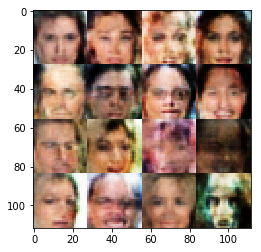

Epoch 1... Step 2410... Discriminator Loss: 0.9375... Generator Loss: 3.8824
Epoch 1... Step 2420... Discriminator Loss: 0.2488... Generator Loss: 3.0659
Epoch 1... Step 2430... Discriminator Loss: 0.2435... Generator Loss: 3.2463
Epoch 1... Step 2440... Discriminator Loss: 0.6383... Generator Loss: 0.8801
Epoch 1... Step 2450... Discriminator Loss: 0.2405... Generator Loss: 1.8640
Epoch 1... Step 2460... Discriminator Loss: 1.1932... Generator Loss: 0.4344
Epoch 1... Step 2470... Discriminator Loss: 1.3203... Generator Loss: 0.3699
Epoch 1... Step 2480... Discriminator Loss: 0.4771... Generator Loss: 1.1875
Epoch 1... Step 2490... Discriminator Loss: 0.5325... Generator Loss: 1.1110
Epoch 1... Step 2500... Discriminator Loss: 1.5648... Generator Loss: 0.2882


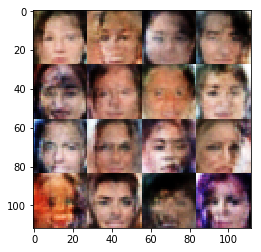

Epoch 1... Step 2510... Discriminator Loss: 1.4432... Generator Loss: 0.3329
Epoch 1... Step 2520... Discriminator Loss: 0.2592... Generator Loss: 1.9033
Epoch 1... Step 2530... Discriminator Loss: 0.3663... Generator Loss: 1.5002
Epoch 1... Step 2540... Discriminator Loss: 1.2647... Generator Loss: 0.4321
Epoch 1... Step 2550... Discriminator Loss: 0.7843... Generator Loss: 0.7673
Epoch 1... Step 2560... Discriminator Loss: 0.3985... Generator Loss: 1.4189
Epoch 1... Step 2570... Discriminator Loss: 0.2482... Generator Loss: 2.2642
Epoch 1... Step 2580... Discriminator Loss: 0.3961... Generator Loss: 1.3193
Epoch 1... Step 2590... Discriminator Loss: 0.4201... Generator Loss: 1.3452
Epoch 1... Step 2600... Discriminator Loss: 1.8877... Generator Loss: 0.2237


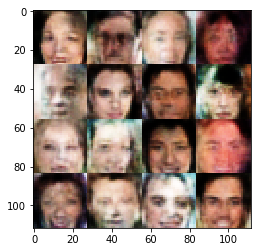

Epoch 1... Step 2610... Discriminator Loss: 0.6432... Generator Loss: 0.8969
Epoch 1... Step 2620... Discriminator Loss: 0.5606... Generator Loss: 1.0472
Epoch 1... Step 2630... Discriminator Loss: 0.4673... Generator Loss: 1.1930
Epoch 1... Step 2640... Discriminator Loss: 0.2554... Generator Loss: 1.7750
Epoch 1... Step 2650... Discriminator Loss: 0.5160... Generator Loss: 1.1163
Epoch 1... Step 2660... Discriminator Loss: 0.1353... Generator Loss: 2.8018
Epoch 1... Step 2670... Discriminator Loss: 1.0880... Generator Loss: 2.6323
Epoch 1... Step 2680... Discriminator Loss: 0.5653... Generator Loss: 3.1287
Epoch 1... Step 2690... Discriminator Loss: 0.3723... Generator Loss: 3.0076
Epoch 1... Step 2700... Discriminator Loss: 1.2990... Generator Loss: 0.4046


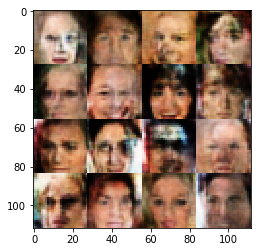

Epoch 1... Step 2710... Discriminator Loss: 1.7528... Generator Loss: 0.2191
Epoch 1... Step 2720... Discriminator Loss: 0.2550... Generator Loss: 2.1529
Epoch 1... Step 2730... Discriminator Loss: 0.1640... Generator Loss: 2.5740
Epoch 1... Step 2740... Discriminator Loss: 0.3228... Generator Loss: 2.4221
Epoch 1... Step 2750... Discriminator Loss: 0.1596... Generator Loss: 2.7703
Epoch 1... Step 2760... Discriminator Loss: 0.1513... Generator Loss: 2.8620
Epoch 1... Step 2770... Discriminator Loss: 0.2483... Generator Loss: 2.8494
Epoch 1... Step 2780... Discriminator Loss: 0.0890... Generator Loss: 3.4226
Epoch 1... Step 2790... Discriminator Loss: 0.9908... Generator Loss: 4.5637
Epoch 1... Step 2800... Discriminator Loss: 0.6647... Generator Loss: 2.3194


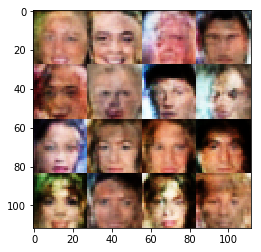

Epoch 1... Step 2810... Discriminator Loss: 0.7440... Generator Loss: 3.0563
Epoch 1... Step 2820... Discriminator Loss: 1.1573... Generator Loss: 1.0076
Epoch 1... Step 2830... Discriminator Loss: 0.2418... Generator Loss: 2.3495
Epoch 1... Step 2840... Discriminator Loss: 0.3475... Generator Loss: 1.8027
Epoch 1... Step 2850... Discriminator Loss: 0.1112... Generator Loss: 3.2119
Epoch 1... Step 2860... Discriminator Loss: 1.3958... Generator Loss: 2.8263
Epoch 1... Step 2870... Discriminator Loss: 0.7157... Generator Loss: 2.4640
Epoch 1... Step 2880... Discriminator Loss: 1.2142... Generator Loss: 2.2421
Epoch 1... Step 2890... Discriminator Loss: 0.4312... Generator Loss: 2.5478
Epoch 1... Step 2900... Discriminator Loss: 0.4491... Generator Loss: 1.2855


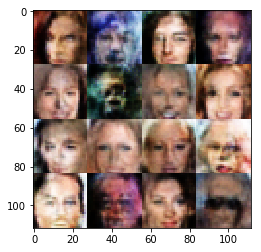

Epoch 1... Step 2910... Discriminator Loss: 0.4366... Generator Loss: 1.2399
Epoch 1... Step 2920... Discriminator Loss: 1.2559... Generator Loss: 0.4438
Epoch 1... Step 2930... Discriminator Loss: 0.3838... Generator Loss: 1.3949
Epoch 1... Step 2940... Discriminator Loss: 0.8259... Generator Loss: 0.7095
Epoch 1... Step 2950... Discriminator Loss: 0.2167... Generator Loss: 2.9695
Epoch 1... Step 2960... Discriminator Loss: 0.1676... Generator Loss: 2.7436
Epoch 1... Step 2970... Discriminator Loss: 1.9772... Generator Loss: 3.3740
Epoch 1... Step 2980... Discriminator Loss: 0.5058... Generator Loss: 2.5939
Epoch 1... Step 2990... Discriminator Loss: 0.3209... Generator Loss: 1.7047
Epoch 1... Step 3000... Discriminator Loss: 0.2329... Generator Loss: 2.0232


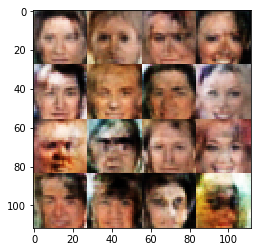

Epoch 1... Step 3010... Discriminator Loss: 0.2023... Generator Loss: 2.5691
Epoch 1... Step 3020... Discriminator Loss: 0.4765... Generator Loss: 1.1060
Epoch 1... Step 3030... Discriminator Loss: 0.8574... Generator Loss: 0.6521
Epoch 1... Step 3040... Discriminator Loss: 0.3694... Generator Loss: 1.5025
Epoch 1... Step 3050... Discriminator Loss: 0.2767... Generator Loss: 1.9010
Epoch 1... Step 3060... Discriminator Loss: 1.8847... Generator Loss: 3.0540
Epoch 1... Step 3070... Discriminator Loss: 0.3697... Generator Loss: 1.7978
Epoch 1... Step 3080... Discriminator Loss: 0.2525... Generator Loss: 2.2131
Epoch 1... Step 3090... Discriminator Loss: 0.1672... Generator Loss: 2.4497
Epoch 1... Step 3100... Discriminator Loss: 2.1932... Generator Loss: 0.1462


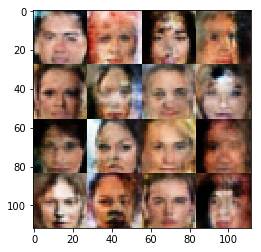

Epoch 1... Step 3110... Discriminator Loss: 1.3429... Generator Loss: 0.3608
Epoch 1... Step 3120... Discriminator Loss: 0.5705... Generator Loss: 1.0103
Epoch 1... Step 3130... Discriminator Loss: 0.7805... Generator Loss: 4.8472
Epoch 1... Step 3140... Discriminator Loss: 0.5980... Generator Loss: 1.7091
Epoch 1... Step 3150... Discriminator Loss: 1.0923... Generator Loss: 3.0524
Epoch 1... Step 3160... Discriminator Loss: 0.3087... Generator Loss: 1.7173


In [38]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.